In [25]:
import numpy as np
import scipy as sp
import scipy.signal as signal
import sympy as sym

from scipy.io import wavfile

import matplotlib.pyplot as plt

from tqdm import tqdm

import utils

from ICA_functions import get_g_dg_d2g_over_dg, calc_h, calc_grad_W

In [26]:
np.random.seed(0) 
PLAY_AUDIO = True

In [27]:
fs_noice, s_noice = wavfile.read('./experiment_1/noice.wav')
fs_stopit, s_stopit = wavfile.read('./experiment_1/stop_it.wav')
fs_yeah, s_yeah = wavfile.read('./experiment_1/yeah_boy.wav')

if not fs_noice == fs_stopit == fs_yeah:
    raise ValueError('Sample rates are different')

Fs = fs_noice

t_length = min(s_noice.shape[0], s_stopit.shape[0], s_yeah.shape[0])
print(f'Number of samples: {t_length}')

s_noice = s_noice[:t_length, 0]
s_stopit = s_stopit[:t_length, 0]
s_yeah = s_yeah[:t_length, 0]


# generate noise
n = np.random.randn(t_length) * np.sqrt(0.2) 

# combine all records into one file
s = np.stack((s_noice, s_stopit, s_yeah, n), axis=1, dtype=np.float64).swapaxes(0, 1)

# power normalization
s = np.einsum('cn,c->cn', s, 1/np.sqrt(np.mean(s**2, axis=-1)))

Number of samples: 186368


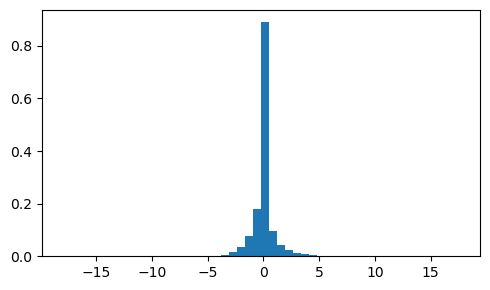

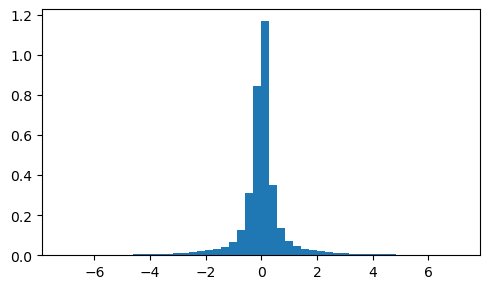

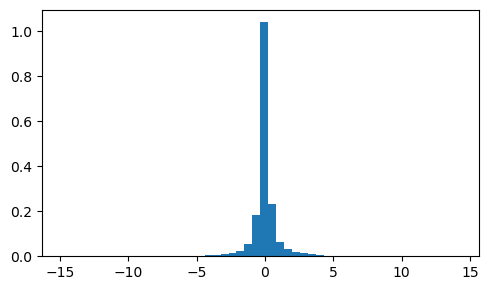

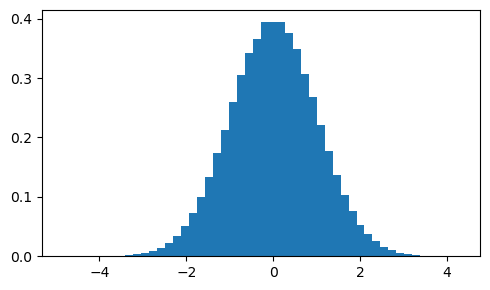

In [28]:
for i in range(s.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(s[i, :], bins=50, density=True)
    plt.tight_layout()
    plt.show()

In [29]:
if PLAY_AUDIO:
    utils.play_audios(s, Fs, norm_coef=0.1)

In [30]:
N = s.shape[0]  # number of source signals
M = N           # number of sensors (M=N)
T = s.shape[1]  # number of time samples (measurements)

W0 = np.eye(N, M, dtype=np.float64)  # unmixing initialization

sym_g = sym.tanh  # assumtion for signals' cdf (must be sympy function) 

g, dg, d2g_over_dg = get_g_dg_d2g_over_dg(sym_g)  # automatic symbolic g''/g' calculation with conversion to numpy

maxiter = 1000

lr = 0.1
lr_gamma = 0.995

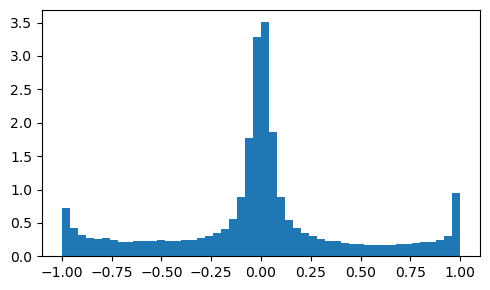

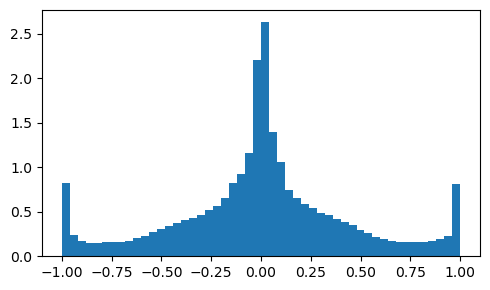

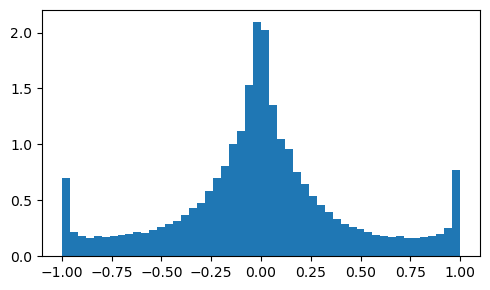

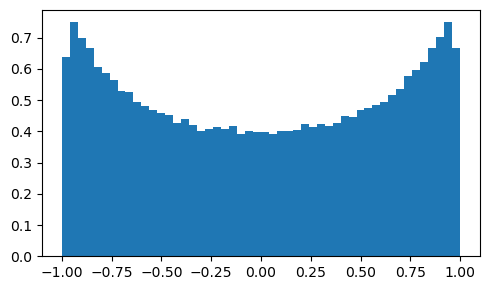

In [31]:
for i in range(s.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(g(s[i, :]), bins=50, density=True)
    plt.tight_layout()
    plt.show()

In [32]:
# A = np.abs(np.random.randn(M, N))     # mixing matrix generation
# np.linalg.cond(A)

In [33]:
A = np.array([
    [1.23, 0.61, 0.39, -0.63],
    [-0.41, 0.98, 0.06, 0.61],
    [0.65, -0.35, 0.18, 1.07],
    [-0.59, 0.38, 0.85, 0.38]
])

np.linalg.cond(A)

2.335483445334413

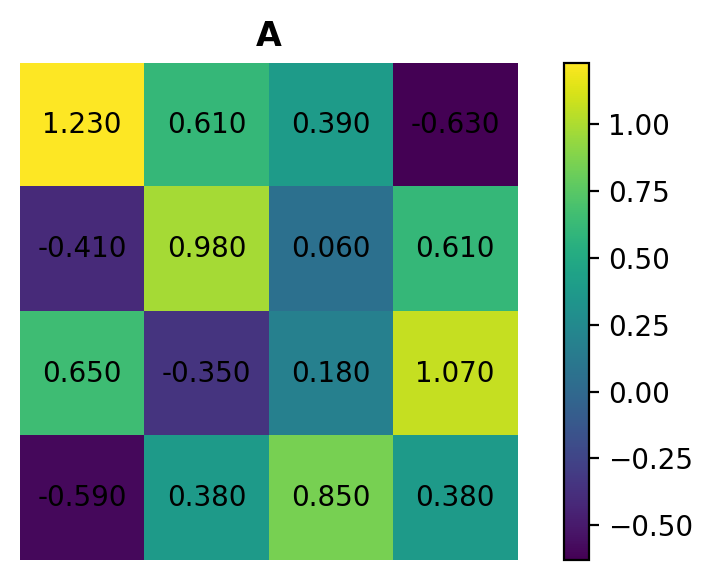

In [34]:
utils.plot_matrix(A, f'$\mathbf{{A}}$')

In [35]:
x = A @ s

W = W0.copy()
y = W @ x

In [37]:
np.mean(s**2), np.mean(x**2), np.mean(y**2)

(0.9999999999999986, 1.754845103586262, 1.754845103586262)

In [38]:
if PLAY_AUDIO:
    utils.play_audios(x, Fs, norm_coef=0.1)

In [39]:
h_log = np.zeros(maxiter)
grad_norm_log = np.zeros(maxiter)

In [40]:
pbar = tqdm(range(maxiter))
for it in pbar:
    y = W @ x
    
    h = calc_h(T, dg(y), W)
    
    grad_W = calc_grad_W(T, x, d2g_over_dg(y), W)
    
    W += lr * grad_W
    lr *= (lr_gamma)
    
    h_log[it] = h
    grad_norm_log[it] = np.linalg.norm(grad_W, ord=2)
    
    if it%20 == 0:
        pbar.set_postfix({'grad_norm' : f"{grad_norm_log[it]:.3g}",
                        'h' : f"{h_log[it]:.3g}"})

100%|██████████| 1000/1000 [00:46<00:00, 21.60it/s, grad_norm=7.29e-05, h=-3.05]


In [41]:
y = W @ x

Rescale signals

In [42]:
y = np.einsum('cn,c->cn', y, 1/np.sqrt(np.mean(y**2, axis=-1)))

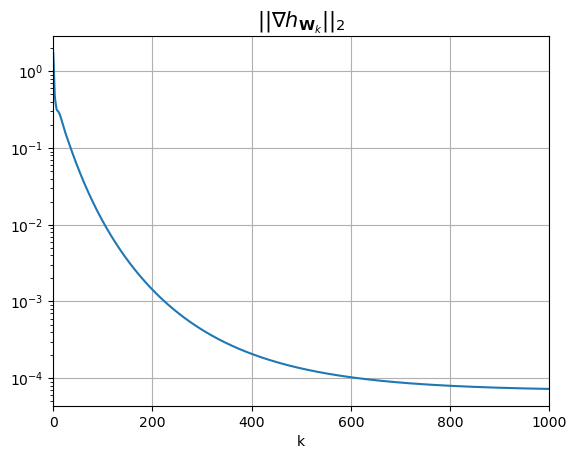

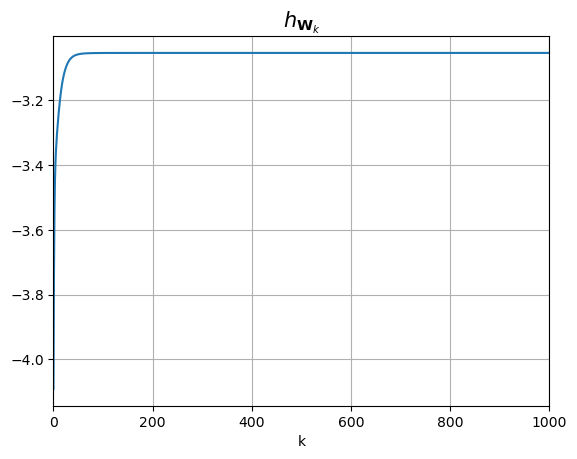

In [48]:
plt.figure()
plt.title(r'$ ||\nabla h_{\mathbf{W}_k}||_{2} $', fontsize=15)
plt.semilogy(grad_norm_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

plt.figure()
plt.title(r'$h_{\mathbf{W}_k}$', fontsize=15)
plt.plot(h_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

In [44]:
if PLAY_AUDIO:
    utils.play_audios(y, Fs, norm_coef=0.1)

In [45]:
np.mean(y**2), np.mean(x**2), np.mean(s**2)

(1.0000000000000002, 1.754845103586262, 0.9999999999999986)

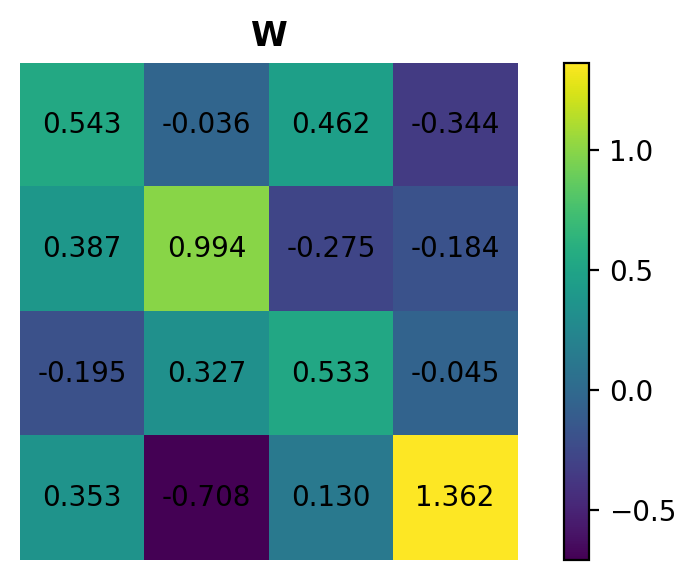

In [46]:
utils.plot_matrix(W, f'$\mathbf{{W}}$')

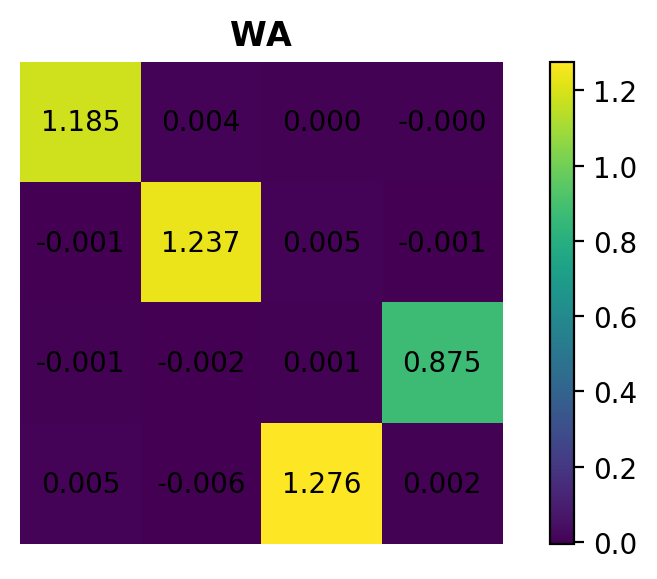

In [47]:
utils.plot_matrix(W@A, f'$\mathbf{{W}}\mathbf{{A}}$')